# Practical work on the Conversion of sampling frequency and STFT


*Based on template provided by R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [1]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import scipy.ndimage.filters

from copy import deepcopy
from math import ceil
import time

## Functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    

def spectog(x,w,R=1, M=32, Nw=31, Nt=10,affich=True):
    Xtilde = np.zeros((M,Nt),dtype=complex)
    for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
        deb = u * R + 1 # début de trame
        fin = deb + Nw # fin de trame
        tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
        X = np.fft.fft(tx,M) # tfd à l'instant b
        if affich:
            Xtilde[:,u] = X
        # opérations de transformation (sur la partie \nu > 0)
        # ....
        Y = X.copy
        # fin des opérations de transformation
        # resynthèse
        # overlap add
    return Xtilde
   

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

def upsampling(x, L):
    zero = np.zeros(len(x)*L)
    zero[::L] = x
    return zero

def downsampling(x, M):
    return x[::M]*M

def delay(x, z):
    zero=np.zeros(len(x))
    if(z<0):
        zero[:len(x) - z*(-1):]=x[z*(-1)::]
    else:
        zero[z::]=x[:len(x) - z:]
    return zero

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [3]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [4]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [5]:
play = False
if play :
    play_sound(sound) 

In [6]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [7]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

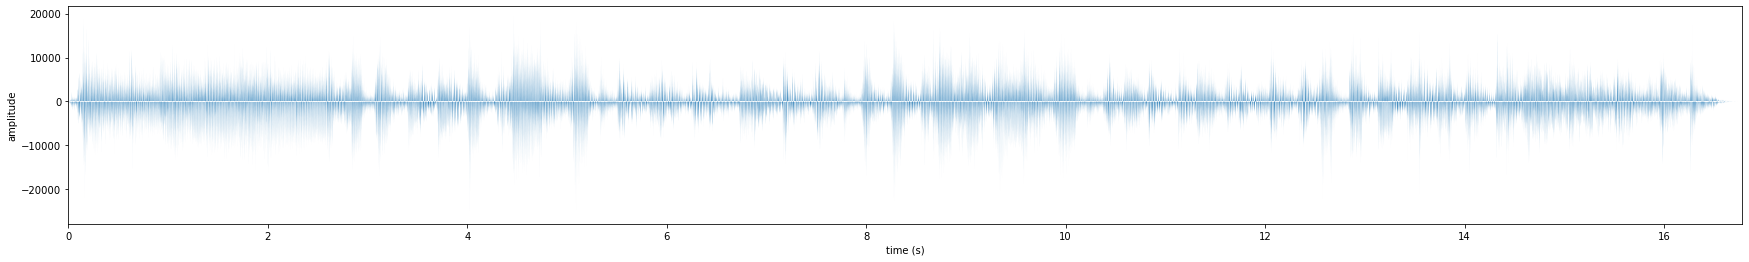

In [8]:
plot_sound(x, times)

# 2. Resampling
## 2.1

![title](img/Q21.png)

The resampling process consist firsly of upsampling the original signal (sampled at $fs$) by L, and then downsampling by M. The result is a signal sampled at $fs*\frac{L}{M}$. In order to do the upsampling operation, we first pad the signal with 0s to reach the desired frequency $fs*L$, and then apply a lowpass filter to remove the spectral content that is now present after frequency $\frac{fs}{L}$. Similarly, in order to downsample the signal sampled at $fs$ we first apply a lowpass filter to remove the spectral content above frequency $\frac{fs}{2M}$, and then keep only one every M samples.

The same filter can be used for both upsampling and downsampling operations: one simply needs to use the filter with lowest cut frequency

## 2.2
### Filter design
Obtain lowpass filter coeficients using remez method. The ideal cut frequency is $\frac{1}{6}$, of 96 kHz which corresponds to 16 kHz. To apply the upsampling, a cut frequency of at most 24 khz is needed, while the downsampling requires 16 kHz. Therefore, in order to use the same filter for both operations, the min{16 kHz, 24 kHz} must be chosen.

In [1]:
h = signal.remez(102,[0,1/6,1/6+1/10,0.5],[1,0])
H = np.abs(np.fft.fft(h))

NameError: name 'scipy' is not defined

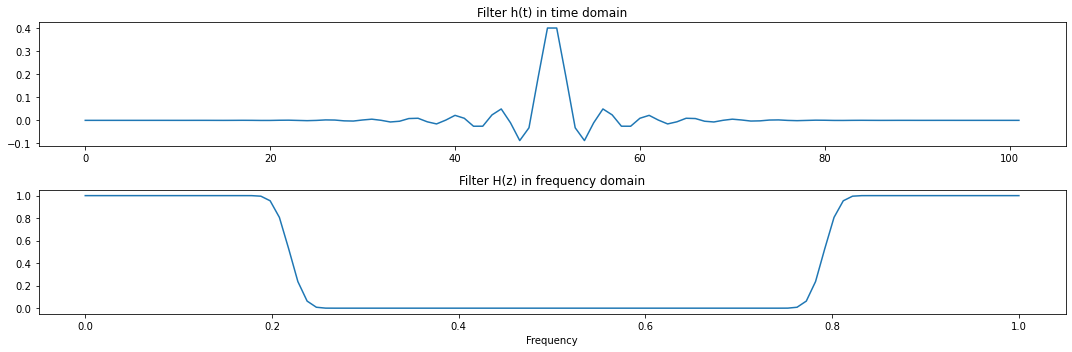

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(h)
plt.title('Filter h(t) in time domain')
plt.subplot(2,1,2)
plt.plot(np.linspace(0,1,len(H)),H)
plt.title('Filter H(z) in frequency domain')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

### Zero padding (upsampling)

In [11]:
x2=upsampling(x, 2)    

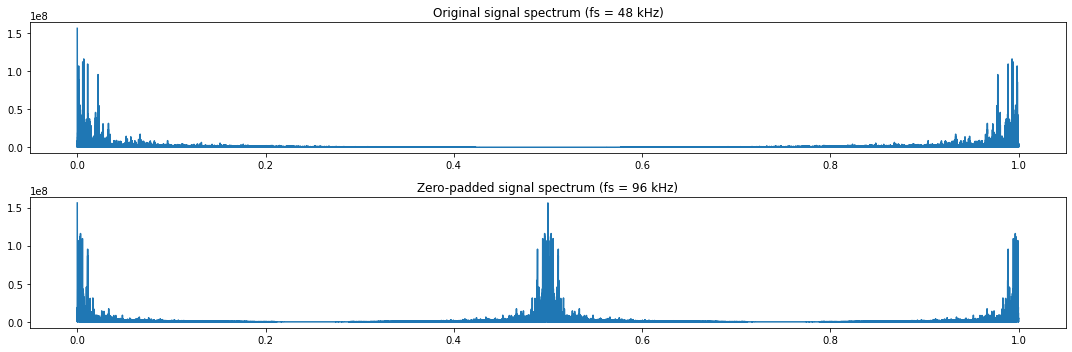

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(np.linspace(0,1,len(x)),np.abs(np.fft.fft(x)))
plt.title('Original signal spectrum (fs = 48 kHz)')
plt.subplot(2,1,2)
plt.plot(np.linspace(0,1,len(x2)),np.abs(np.fft.fft(x2)))
plt.title('Zero-padded signal spectrum (fs = 96 kHz)')
plt.tight_layout()

plt.show()

### Applying Filter h (interpolation)

In [13]:
x_filtered = scipy.ndimage.filters.convolve(x2,h)

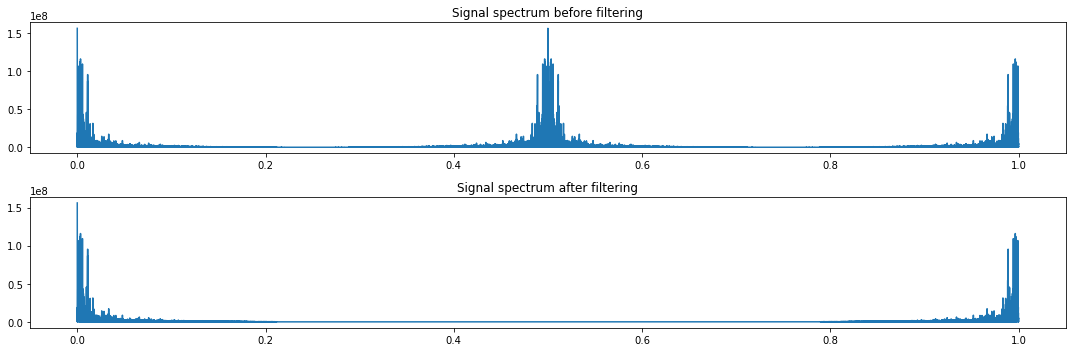

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(np.linspace(0,1,len(x2)),np.abs(np.fft.fft(x2)))
plt.title('Signal spectrum before filtering')
plt.subplot(2,1,2)
plt.plot(np.linspace(0,1,len(x_filtered)),np.abs(np.fft.fft(x_filtered)))
plt.title('Signal spectrum after filtering')
plt.tight_layout()
plt.show()

### Removing samples (downsampling)

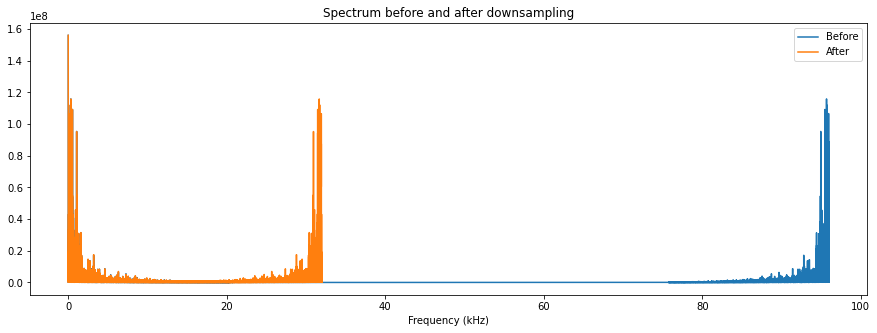

In [15]:
#y = x_filtered[::3]*3

y = downsampling(x_filtered, 3)

plt.figure(figsize=(15,5))
plt.plot(np.linspace(0,96,len(x_filtered)),np.abs(np.fft.fft(x_filtered)))
plt.plot(np.linspace(0,32,len(y)),np.abs(np.fft.fft(y)))
plt.xlabel('Frequency (kHz)')
plt.title('Spectrum before and after downsampling')
plt.legend(['Before', 'After'])
plt.show()

### Save resampled singnal to file '32kHz.wav' 

In [16]:
from scipy.io.wavfile import write
write('32kHz.wav',32000,np.array(y,dtype=np.int16))

## 2.3

To verify this equivalence one has to apply a few properties. Firstly transform the middle block in order to apply Noble identities. After the Noble identities are applied one must swap the upscaling and downscaling blocks, we can do this because they are coprime.

![title](img/Q23.png)

## 2.4 & 2.5

The polyphase decomposition applied is the one below. It was obtained by applying a type II polyphase decomposition and considering the resulting block diagram as a block. This block was subjected to a type I polyphase decomposition resulting in the diagram below

![title](img/Q24.png)

To compare the efficiency of both filters we used the time.time function. First we calculated the time from 2.2

In [17]:
t = time.time()
x2=upsampling(x, 2)
x_filtered = scipy.ndimage.filters.convolve(x2,h)
y = downsampling(x_filtered, 3)
print(f'The unoptimized version took: {time.time()-t}')

The unoptimized version took: 0.2120800018310547


Then we implemented the diagram above. However, we implemented it linearly, thus, because the diagram branches out 6 times we had to divide the time by 6 in order to obtain an accurate approximation.

In [18]:
yl=list(range(6))
t2 = time.time()
yl[0]=delay(upsampling(scipy.ndimage.filters.convolve(downsampling(x, 3), h[::6]), 2), -1)
yl[1]=delay(upsampling(scipy.ndimage.filters.convolve(downsampling(delay(x, -1), 3), h[1::6]), 2), -1)
yl[2]=delay(upsampling(scipy.ndimage.filters.convolve(downsampling(delay(x, -2), 3), h[2::6]), 2), -1)
yl[3]=upsampling(scipy.ndimage.filters.convolve(downsampling(x, 3), h[3::6]), 2)
yl[4]=upsampling(scipy.ndimage.filters.convolve(downsampling(delay(x, -1), 3), h[4::6]), 2)
yl[5]=upsampling(scipy.ndimage.filters.convolve(downsampling(delay(x, -2), 3), h[5::6]), 2)
print(f'The optimized version took: {(time.time()-t2)/6}')

yop = np.zeros(np.shape(yl)[1])
for i in range(6):
    yop[::]=yl[i][::]+yop[::]
write('polyphase.wav',32000,np.array(yop,dtype=np.int16))

The optimized version took: 0.010175824165344238


# STFT audio equalization
## 3.1 Signal analysis with the STFT

In [19]:
N = x.shape[0] # % longueur du signal
Nw = 31
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = Nw/4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 1024 # ordre de la tfd
L = M/2+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

### a) DFT of Hanning window
 The width of the main lobe is $\frac{4}{N_w}$, where $N_w$ is the window size

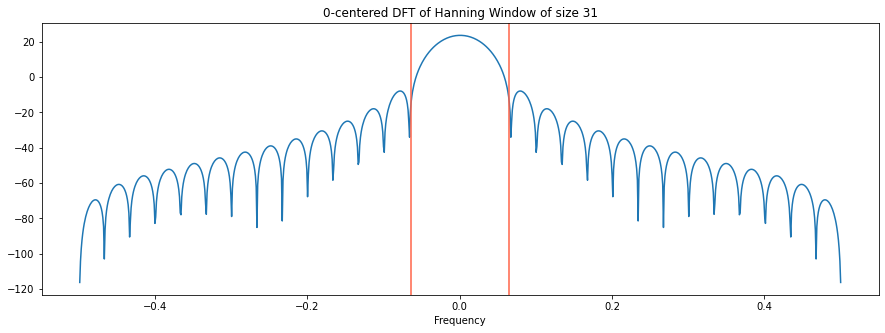

In [20]:
A = np.fft.fft(w, M)
mag = np.abs(np.fft.fftshift(A))    # Shifts fft 

freq = np.linspace(-0.5, 0.5, len(A))   #Frequency values

with np.errstate(divide='ignore', invalid='ignore'):
    response = 20 * np.log10(mag)

plt.figure(figsize=(15,5))
plt.plot(freq, response)
plt.axvline(x=2/Nw, ymin=0, ymax=1,c='tomato')
plt.axvline(x=-2/Nw, ymin=0, ymax=1,c='tomato')
plt.xlabel('Frequency')
plt.title('0-centered DFT of Hanning Window of size '+ str(Nw))

# Plots window in time domain
#plt.figure(figsize=(15,5))
#plt.plot(w)
plt.show()

### b)
For a given $\lambda$ (frequency) the equation 

\begin{equation}
W_x(\lambda,b) = \sum_{n\in\mathbb{Z}}^{} x(n)w(n-b)e^{-j2\pi \lambda n},
\end{equation} 
 can be seen as the convolution of the window w(n) with the signal x(n) which has been modulated by the exponential $e^{-j2\pi \lambda n}$. Therefore, in the frequency domain, the spectrum of x(n) is shifted by $\lambda$ and then filtered by the lowpass filter W(z). The lowpass filter extracts the $\lambda$ frequency component from a given window in the input signal x(n).
 
Since the filter has an odd length and is symmetric, it is a type I FIR filter.

### c)

The convention used in this notebook is the "band-pass convention". 

\begin{equation}
\widetilde{X}(\lambda,b) = \sum_{n\in\mathbb{Z}}^{} x(n+b)w(n)e^{-j2\pi \lambda n},
\end{equation} 

Similarly to the "low-pass convention", the exponential component in the equation modulates a signal, this time the window w. In the frequency domain, the spectrum of $w(n)$ is shifted by $\lambda$, which acts as a band-pass filter, filtering the signal $x(n)$ at frequency $\lambda$ . The filtering operation is the result of the convolution, in the time domain, between $x(n)$ and $w(n)e^{-j2\pi \lambda n}$




### d)
Computing signal $x_k(u)$ =$\widetilde{X}(k,u)$ for k=3 and writing the result to audio file '3d.wav'. The signal is complex, therefore it is necessary to extract the real component.

In [21]:
# Sets up parameters
k=3        # Frequency channel
Nw = 31
M=32
R=1
Nt = np.rint((N - Nw)/R)
Nt = Nt.astype(int)
w = np.hanning(Nw) #
ws = w.copy; 
L = M/2+1

# Calculates the spectogram Xtilde
Xtilde1 = spectog(x, w, R=R,M=M,Nw=Nw,Nt=Nt)
# Evaluates at frequency channel k
xk = Xtilde1[k,:]
rexk = np.real(xk)

write('3d',48000,np.array(rexk,dtype=np.int16))

/Users/gabrielmedeiros/opt/anaconda3/envs/MODS202/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


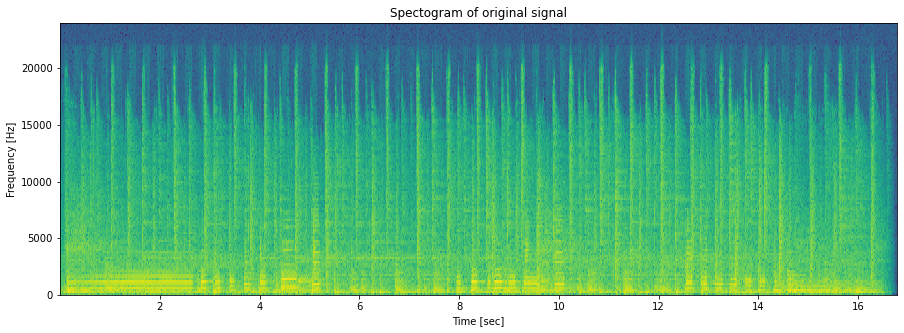

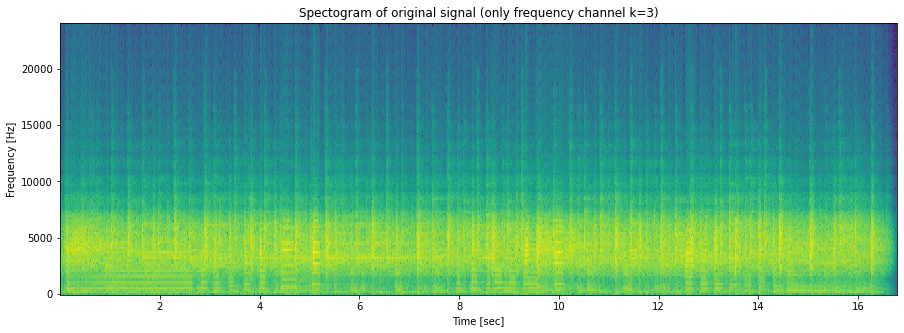

In [22]:
plt.figure(figsize=(15,5))

f, t, Sxx = scipy.signal.spectrogram(x, 48000)
plt.pcolormesh(t, f, 20*np.log10(Sxx))
plt.ylabel('Frequency [Hz]')

plt.xlabel('Time [sec]')
plt.title('Spectogram of original signal')
plt.show()

plt.figure(figsize=(15,5))
f, t, Sxx = scipy.signal.spectrogram(rexk, 48000)

plt.pcolormesh(t, f, 20*np.log10(Sxx), shading='auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectogram of original signal (only frequency channel k=3)')
plt.show()



### Comparison with butterworth filter 
fc = 4500 Hz, equivalent to frequency channel k = 3 in the STFT

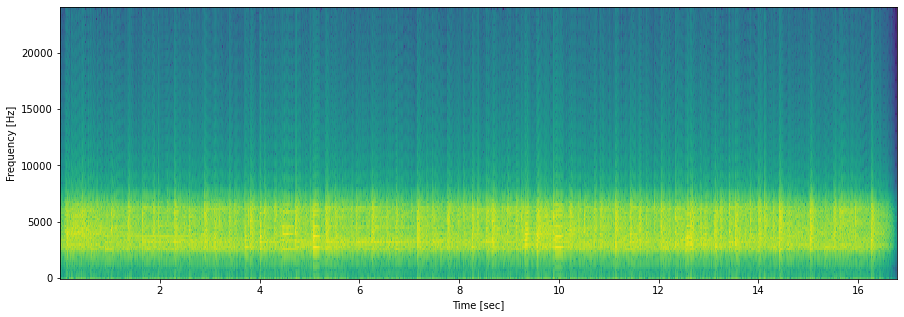

In [23]:
f_desired = 4500
f_total = 48000
Nw_form = 31
b_coef, a_coef = scipy.signal.butter(9, [2*f_desired/f_total-2.5/(Nw_form), 2*f_desired/f_total+2.5/(Nw_form)], btype='band')
y = scipy.signal.filtfilt(b_coef, a_coef, x)
write('4d.wav',48000,np.array(y,dtype=np.int16))

plt.figure(figsize=(15,5))
f, t, Sxx = scipy.signal.spectrogram(y, 48000)

plt.pcolormesh(t, f, 20*np.log10(Sxx), shading='auto')

plt.ylabel('Frequency [Hz]')

plt.xlabel('Time [sec]')

plt.show()

## 3.2 Reconstruction

### e)

In [24]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output

In [25]:
f_75 = ola(w=w, hop=int(3*len(w)/4), Nb=25)
f_50 = ola(w=w, hop=int(len(w)/2), Nb=25)

Considering 

\begin{equation}
f(n) = \sum_{u\in\mathbb{Z}}^{} w(n-uR)w_s(n-uR),
\end{equation} 

We can see that the f(n) constructed from the overlap-add method applied to the window w, with 75% overlap, is not f(n) = 1 $\forall$ n (first subplot). That is the case for 50% overlap, that can be seen in the second subplot. 

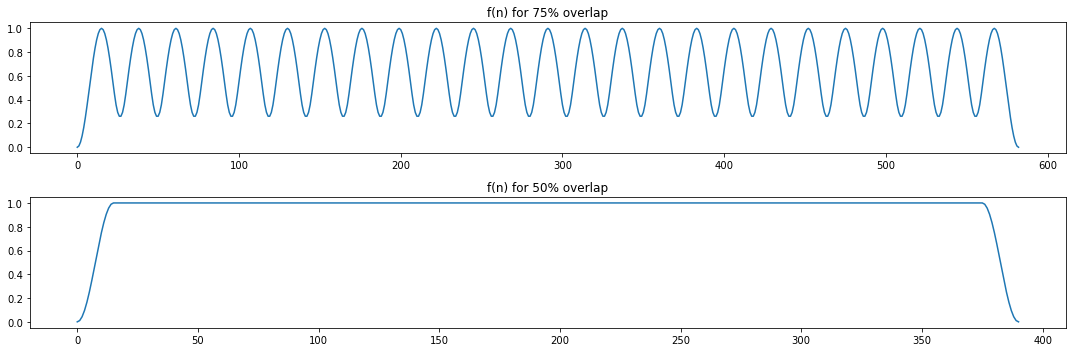

In [26]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot(f_75)
plt.title('f(n) for 75% overlap')
plt.subplot(2,1,2)
plt.plot(f_50)
plt.title('f(n) for 50% overlap')
plt.tight_layout()

### f)

Defining resynthesis function

In [27]:
def resynthesis(xtilde,w,R=1, M=32, Nw=31, N=1):
    X = np.zeros(N)
    for b in np.arange(0,xtilde.shape[1]):
        
        deb = R*b + 1 # début de trame
        fin = deb + Nw # fin de trame
        
        bx = xtilde[:,b]
        inv = np.fft.ifft(bx)
        
        tx = np.multiply(inv[:Nw],w)
        
        
        X[np.arange(deb.astype(int),fin.astype(int))] = X[np.arange(deb.astype(int),fin.astype(int))] + tx
        
    return X

In [28]:
# Sets up parameters
Nw = 31
M=32
R=7
Nt = np.rint((N - Nw)/R)
Nt = Nt.astype(int)
w = np.hanning(Nw) #
ws = w.copy; 
L = M/2+1

# Calculates the spectogram Xtilde2
Xtilde2 = spectog(x, w, R=R,M=M,Nw=Nw,Nt=Nt)

Applies resynthesis and saves to file 'reconstructed.wav'

In [29]:

X = resynthesis(Xtilde2, w, R=R, M=M, Nw=Nw,N=N)

write('reconstructed.wav',48000,np.array(X,dtype=np.int16))

/Users/gabrielmedeiros/opt/anaconda3/envs/MODS202/lib/python3.7/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


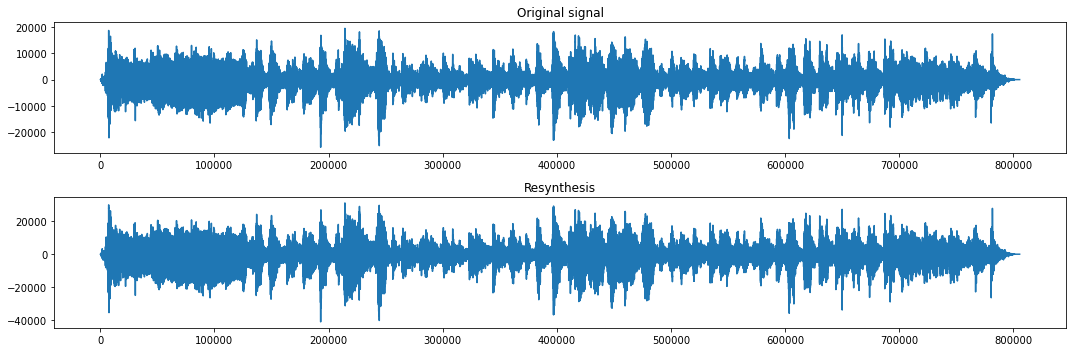

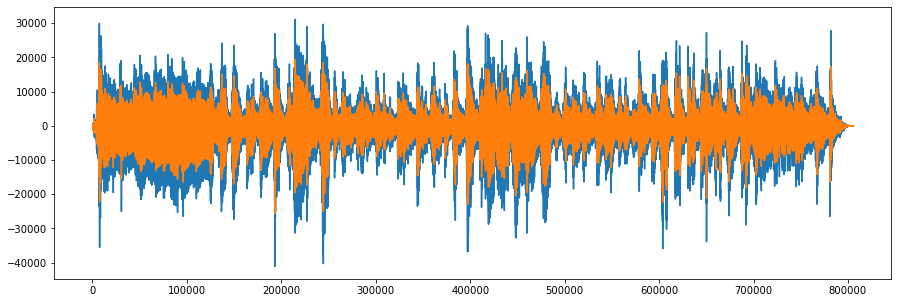

0.622226711532389

In [30]:
plt.figure(figsize=(15,5))

plt.subplot(2,1,1)
plt.plot(x)
plt.title('Original signal')
plt.subplot(2,1,2)
plt.plot(X)
plt.title('Resynthesis')
plt.tight_layout()

plt.figure(figsize=(15,5))
plt.plot(X)
plt.plot(x)
plt.show()
np.sum(x)/np.sum(X) # scaling relationship amplitude

Despite having a correct waveform, unfortunately the amplitude of the reconstructed signal wasn't what was expected.

## 3.3 STFT audio equalizer
### g)
Defines equalizer function and declares weight vector for the $\frac{M}{2}+1$ channels. The weights are applied in a symmetrical way for indices 1,2,...M-1.

In [31]:

def equalizer(xtilde, weights):
    a = xtilde.copy()
    l = xtilde.shape[0]
    for k in np.arange(0, int(xtilde.shape[0]/2+1)):
        a[k,:] = xtilde[k,:]*weights[k]
        a[l-k-1] = xtilde[l-k-1,:]*weights[k]
    return a

In [32]:
# Weights start as 1
weights = np.ones(int(M/2)+1)

# Alter gain of certain frequency bands
weights[0:5]=0


b = np.real(Xtilde2).copy()
Y = equalizer(b,weights)

Y2 = resynthesis(Y, w, R=R, M=M, Nw=Nw,N=N)

# Scaling and clipping if necessary
#2 = Y2 * sum(x)/sum(Y2)
# = np.clip(Y2, a_min = -30000, a_max = 30000)

write('equalizer.wav',48000,np.array(Y2,dtype=np.int16))

/Users/gabrielmedeiros/opt/anaconda3/envs/MODS202/lib/python3.7/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


Spectogram of original and equalized signal

/Users/gabrielmedeiros/opt/anaconda3/envs/MODS202/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


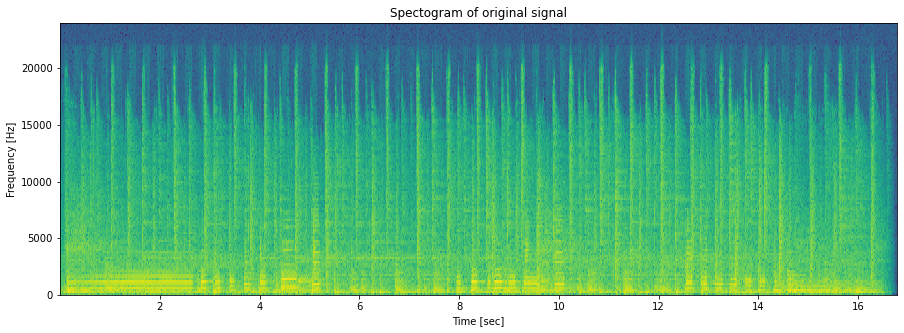

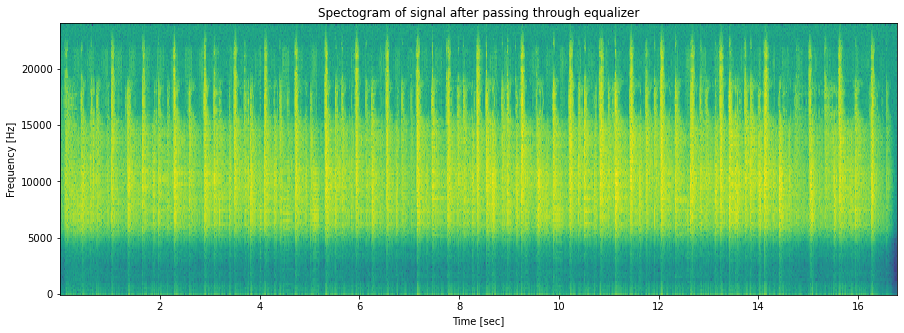

In [33]:
plt.figure(figsize=(15,5))

f, t, Sxx = scipy.signal.spectrogram(x, 48000)
plt.pcolormesh(t, f, 20*np.log10(Sxx))
plt.ylabel('Frequency [Hz]')

plt.xlabel('Time [sec]')
plt.title('Spectogram of original signal')
plt.show()


plt.figure(figsize=(15,5))
f, t, Sxx = scipy.signal.spectrogram(Y2, 48000)

plt.pcolormesh(t, f, 20*np.log10(Sxx), shading='auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectogram of signal after passing through equalizer')
plt.show()